In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import pandas as pd

c:\Users\DMQA\anaconda3\envs\cho\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

In [3]:
dataset = 'healthcare' #choose 'healthcare' or 'airquality'
datafolder = 'physio_fold0_20240428_194238' # set the folder name
nsample = 50 # number of generated sample

path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk' 
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load( f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

if dataset == 'airquality':
    path = 'data/pm25/pm25_meanstd.pk'
    with open(path, 'rb') as f:
        train_mean,train_std = pickle.load(f)
    train_std_cuda = torch.from_numpy(train_std).cuda()
    train_mean_cuda = torch.from_numpy(train_mean).cuda()
    all_target_np=(all_target_np*train_std+train_mean)
    samples=(samples*train_std_cuda+train_mean_cuda)

In [4]:

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

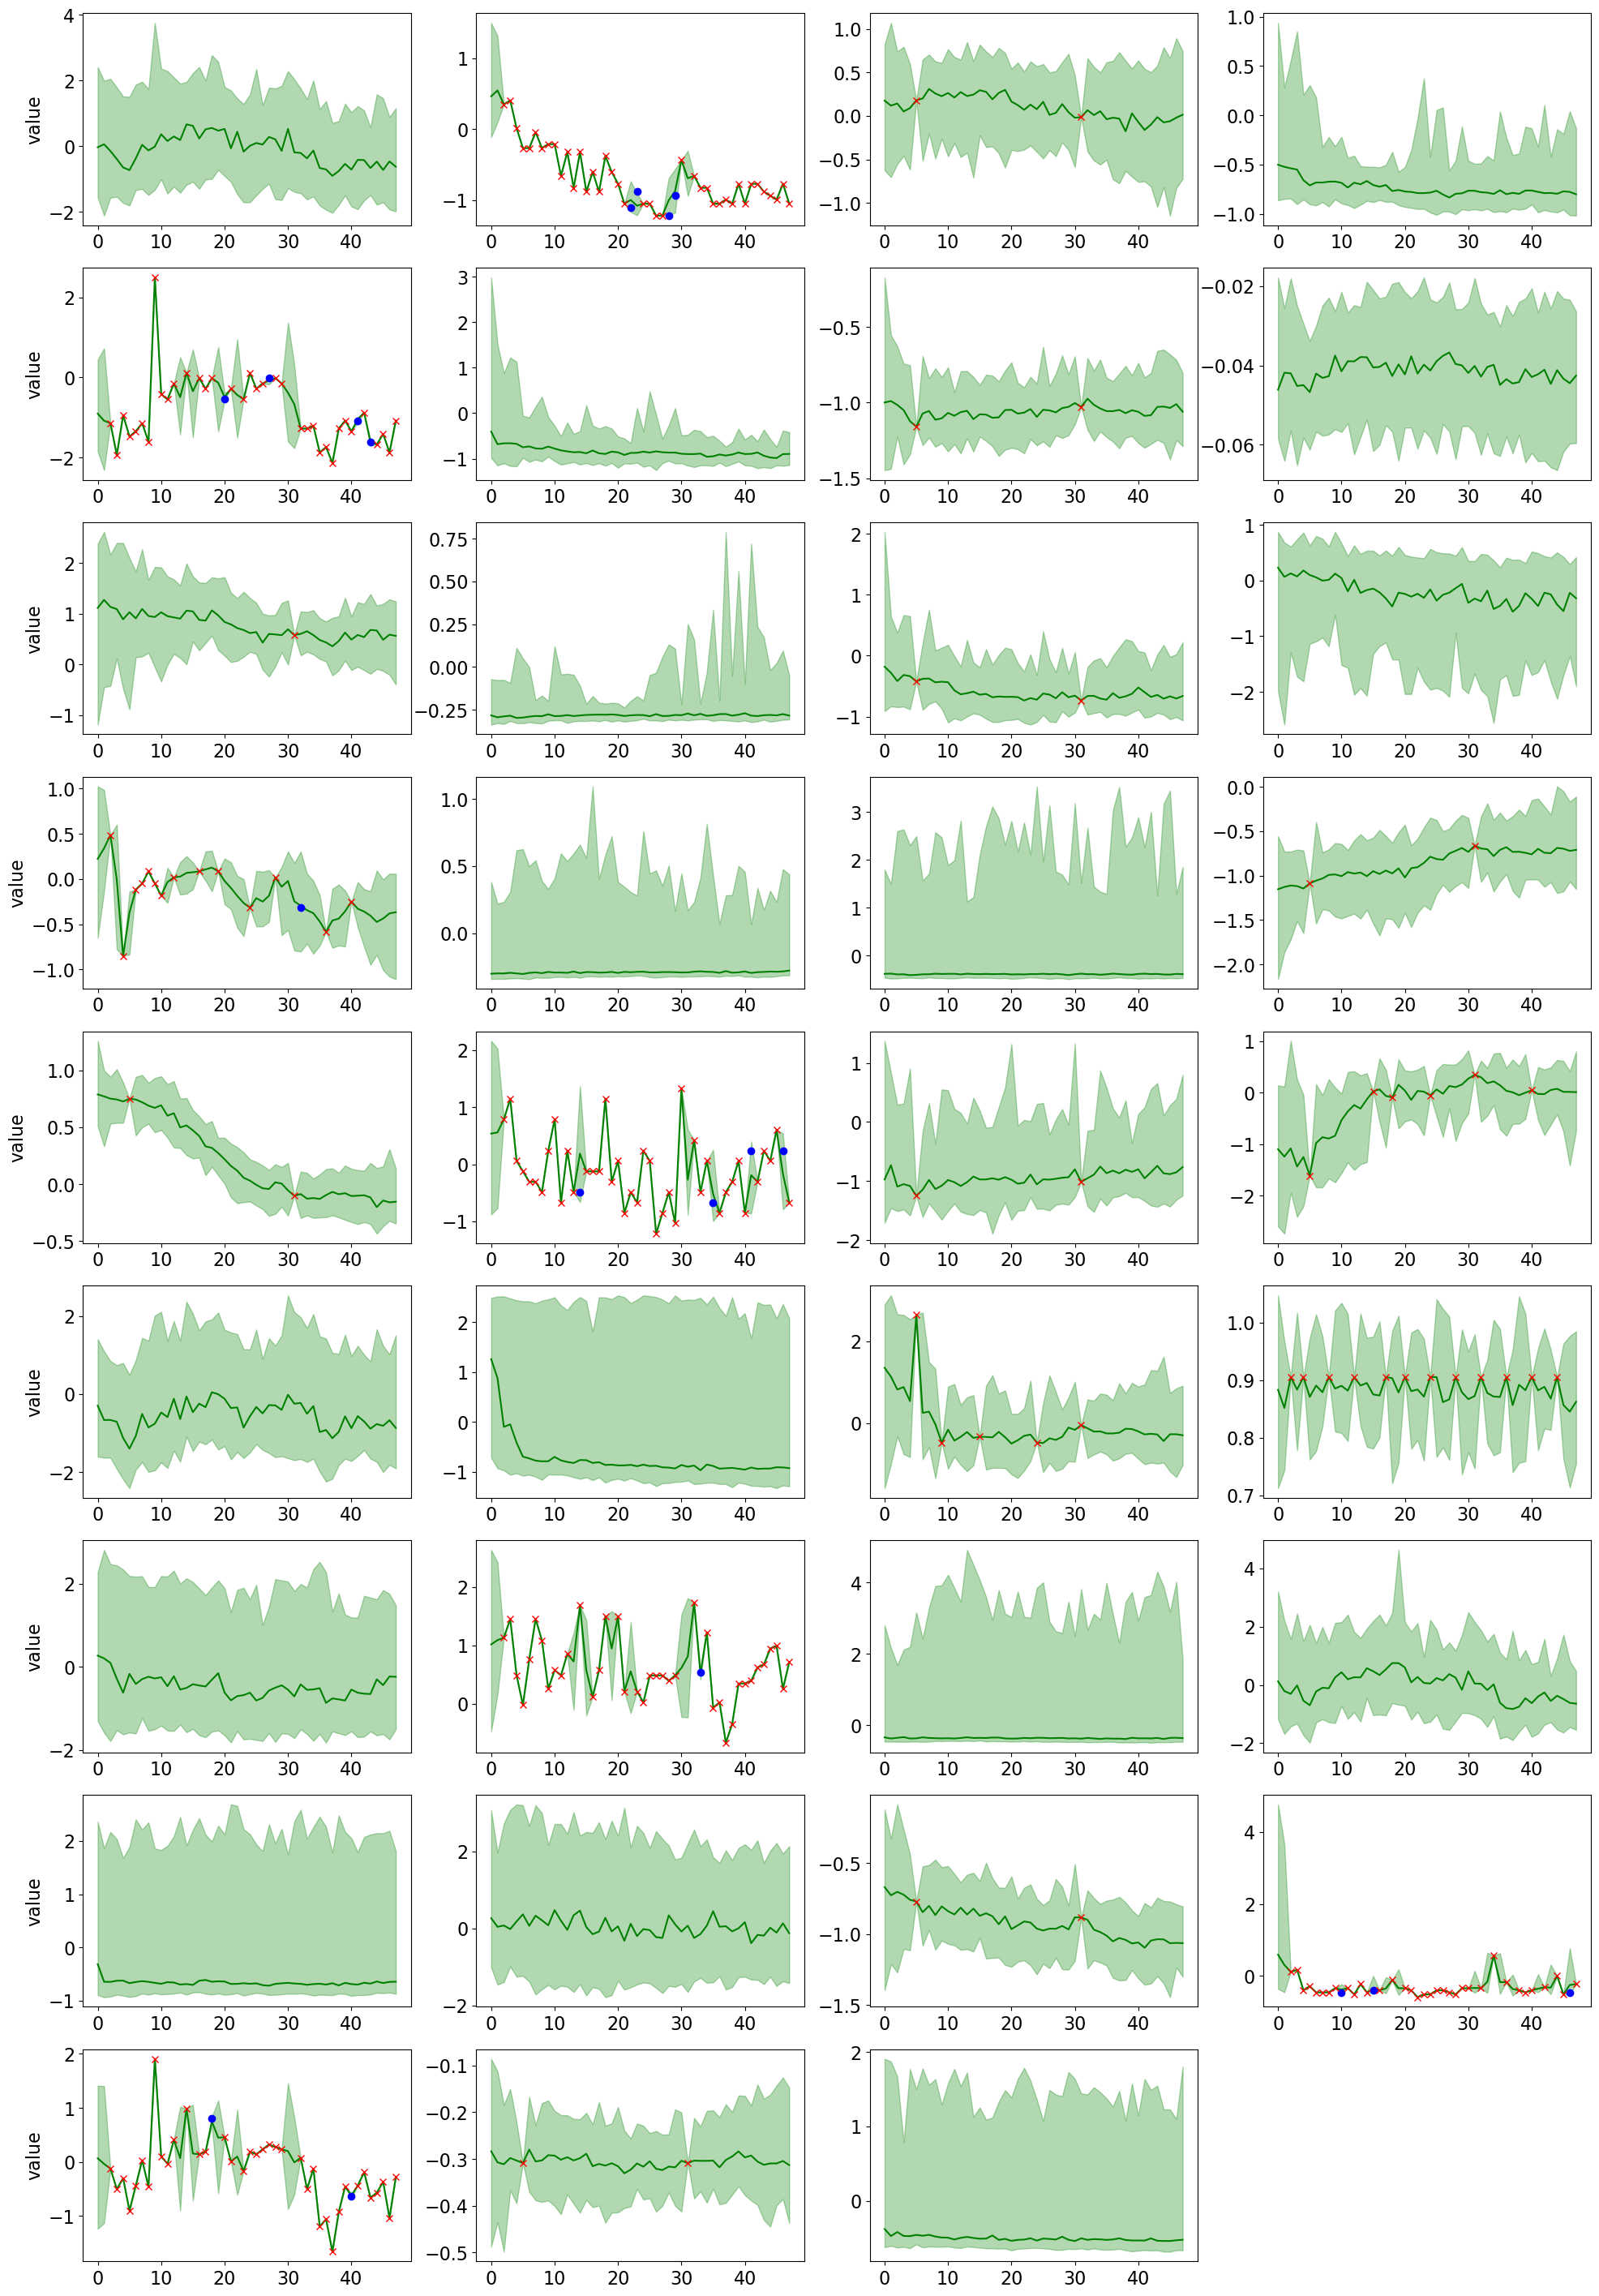

In [5]:
###healthcare###
dataind = 3 #change to visualize a different time-series sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')


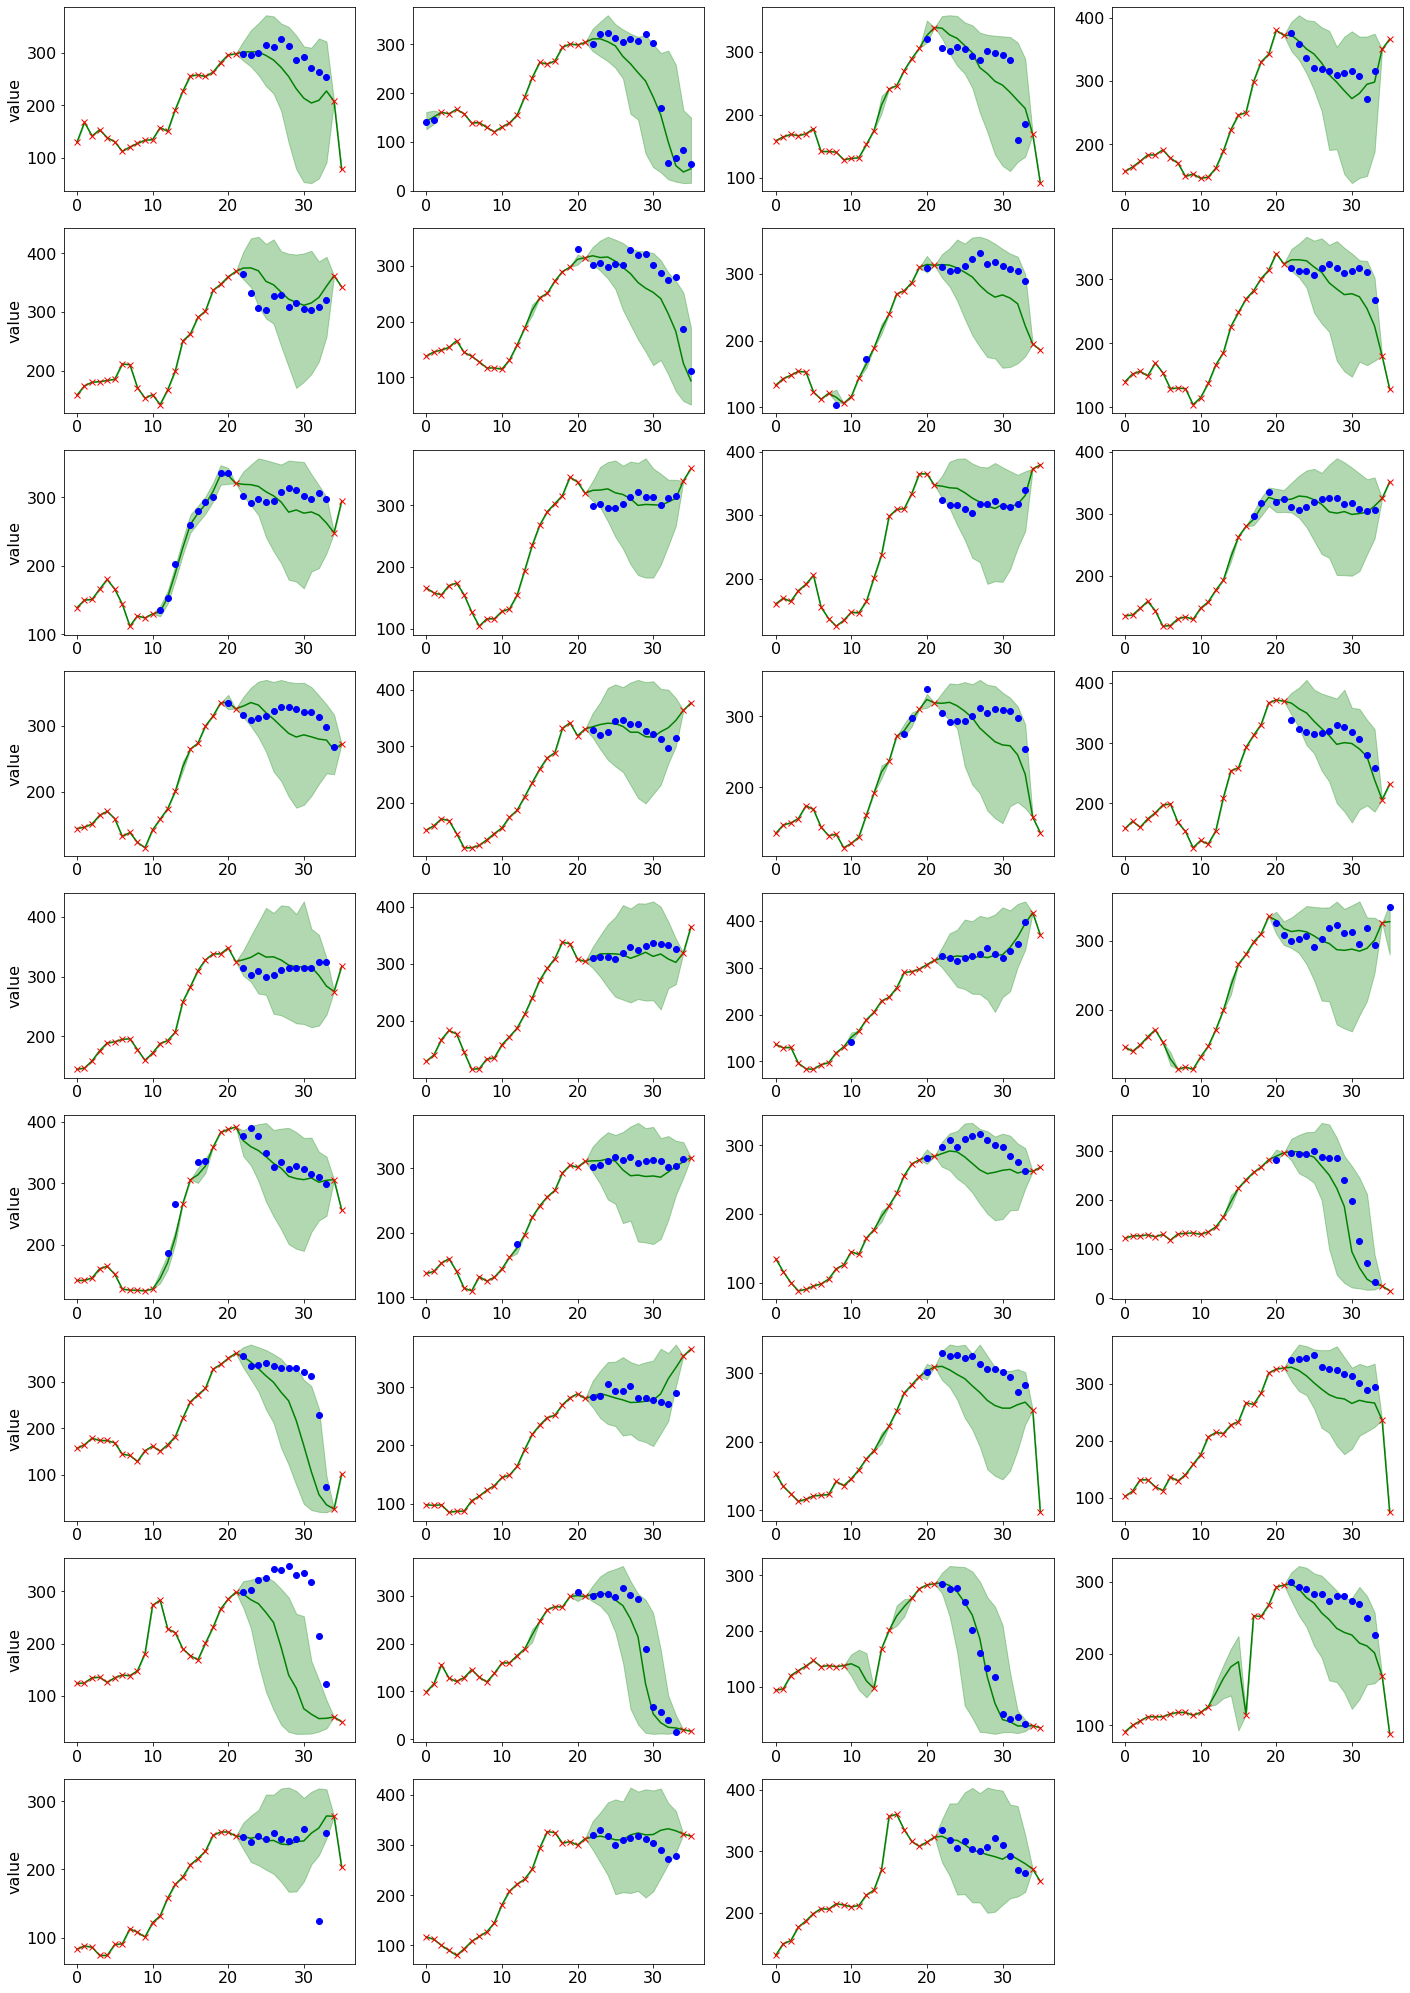

In [32]:
###airquality###
dataind = 10 #change to visualize a different sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
